Energy Consumption Timeseries studies - SARIMAX

Levy Galas Jacob
Linkedin: https://www.linkedin.com/in/levygjacob/
Github: github.com/levygjacob

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
df = pd.read_csv(r"Electric_Production.csv")
df.head()

,DATE,Value
0,01-01-1985,72.5052
1,02-01-1985,70.6720
2,03-01-1985,62.4502
3,04-01-1985,57.4714
4,05-01-1985,55.3151


In [5]:
df['DATE'] = pd.to_datetime(df['DATE'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    397 non-null    datetime64[ns]
 1   Value   397 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.3 KB


In [6]:
df.set_index('DATE',inplace=True)
df.head()

,Value
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


# Feature Creation for EDA

In [7]:
def create_date_features(df):
    # Create a copy to avoid modifying the original DataFrame
    df_new = df.copy()
    
    # Basic date components
    df_new['date'] = df_new.index
    df_new['day'] = df_new.index.day
    df_new['month'] = df_new.index.month
    df_new['year'] = df_new.index.year
    
    # Day-based features
    df_new['day_of_week'] = df_new.index.dayofweek  # Monday=0, Sunday=6
    df_new['is_weekend'] = df_new['day_of_week'].isin([5, 6]).astype(int)
    df_new['day_of_year'] = df_new.index.dayofyear
    df_new['day_name'] = df_new.index.day_name()
    
    # Week-based features
    df_new['week_of_year'] = df_new.index.isocalendar().week
    
    # Month-based features
    df_new['quarter'] = df_new.index.quarter
    df_new['month_name'] = df_new.index.month_name()
    df_new['days_in_month'] = df_new.index.days_in_month
    
    # Seasonal features
    df_new['season'] = pd.cut(df_new['month'], 
                             bins=[0, 3, 6, 9, 12], 
                             labels=['Winter', 'Spring', 'Summer', 'Fall'], 
                             include_lowest=True)
    
    return df_new

In [8]:
newDf = create_date_features(df)
newDf.head()

,Value,date,day,month,year,day_of_week,is_weekend,day_of_year,day_name,week_of_year,quarter,month_name,days_in_month,season
DATE,,,,,,,,,,,,,,
1985-01-01,72.5052,1985-01-01,1,1,1985,1,0,1,Tuesday,1,1,January,31,Winter
1985-02-01,70.6720,1985-02-01,1,2,1985,4,0,32,Friday,5,1,February,28,Winter
1985-03-01,62.4502,1985-03-01,1,3,1985,4,0,60,Friday,9,1,March,31,Winter
1985-04-01,57.4714,1985-04-01,1,4,1985,0,0,91,Monday,14,2,April,30,Spring
1985-05-01,55.3151,1985-05-01,1,5,1985,2,0,121,Wednesday,18,2,May,31,Spring


In [9]:
newDf.rename(columns={'Value':'Energy Consumption'},inplace=True)
newDf.columns

Index(['Energy Consumption', 'date', 'day', 'month', 'year', 'day_of_week',
       'is_weekend', 'day_of_year', 'day_name', 'week_of_year', 'quarter',
       'month_name', 'days_in_month', 'season'],
      dtype='object')

In [10]:
newDf.head()

,Energy Consumption,date,day,month,year,day_of_week,is_weekend,day_of_year,day_name,week_of_year,quarter,month_name,days_in_month,season
DATE,,,,,,,,,,,,,,
1985-01-01,72.5052,1985-01-01,1,1,1985,1,0,1,Tuesday,1,1,January,31,Winter
1985-02-01,70.6720,1985-02-01,1,2,1985,4,0,32,Friday,5,1,February,28,Winter
1985-03-01,62.4502,1985-03-01,1,3,1985,4,0,60,Friday,9,1,March,31,Winter
1985-04-01,57.4714,1985-04-01,1,4,1985,0,0,91,Monday,14,2,April,30,Spring
1985-05-01,55.3151,1985-05-01,1,5,1985,2,0,121,Wednesday,18,2,May,31,Spring


In [11]:
newDf.to_csv('Electric_Production_enriched.csv', index=True)  # Salvando como CSV sem o índice


**Data visualization**

<Axes: xlabel='DATE'>

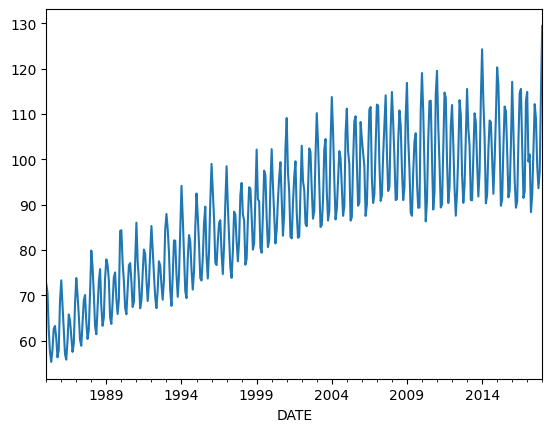

In [12]:
newDf['Energy Consumption'].plot()

<Axes: xlabel='DATE'>

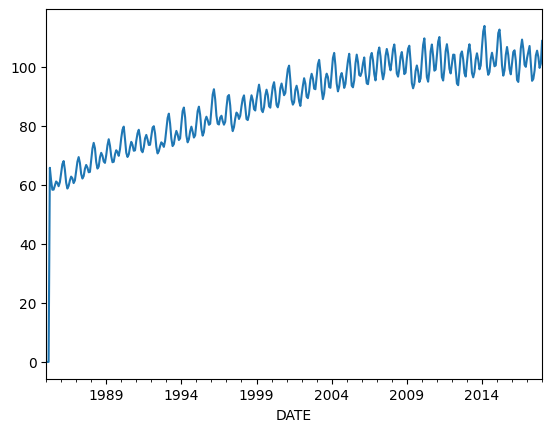

In [13]:
newDf['Energy Consumption'].rolling(window=4).mean().fillna(0).plot()

<Axes: xlabel='year,quarter'>

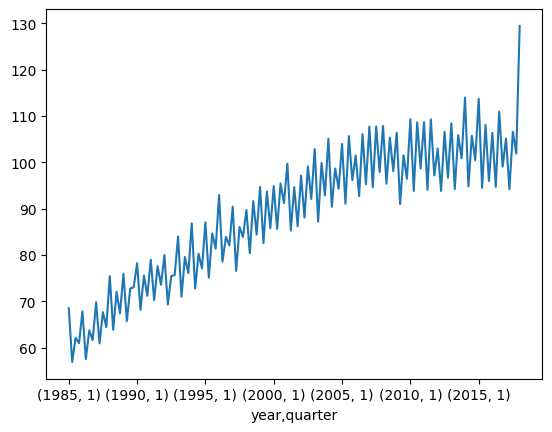

In [14]:
newDf.groupby(['year','quarter'])['Energy Consumption'].mean().plot()

<Axes: xlabel='year'>

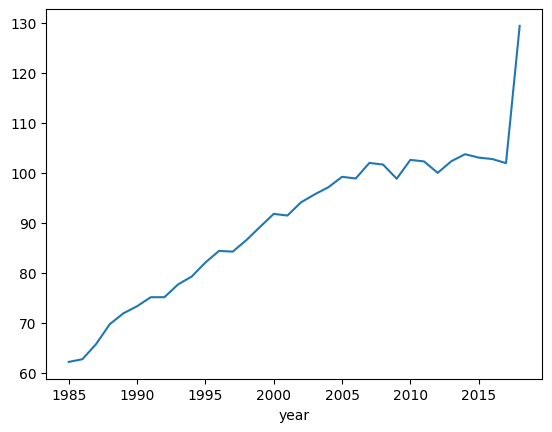

In [15]:
newDf.groupby(['year'])['Energy Consumption'].mean().plot()

C:\Users\levyg\AppData\Local\Temp\ipykernel_4632\1161713149.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  newDf.groupby(['season'])['Energy Consumption'].mean().plot(kind='bar')


<Axes: xlabel='season'>

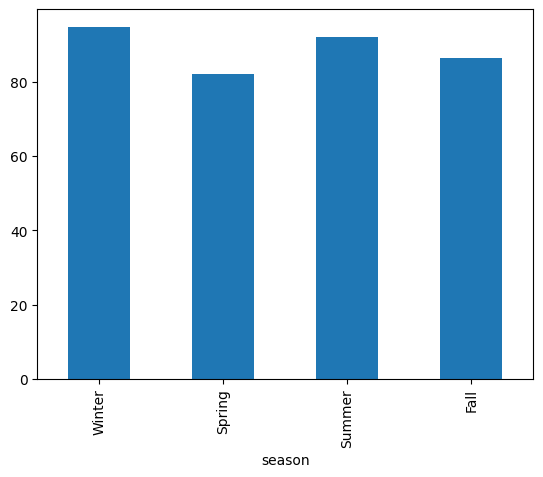

In [16]:
newDf.groupby(['season'])['Energy Consumption'].mean().plot(kind='bar')

Winter shows highest energy consumption followed by summer while spring shows least energy consumption.

<Axes: xlabel='month'>

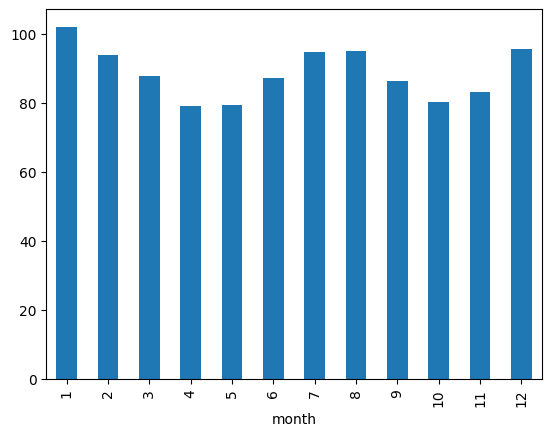

In [17]:
newDf.groupby(['month'])['Energy Consumption'].mean().plot(kind='bar')

January shows highest energy consumption. 

# Time Series Analysis.

In [18]:
season = seasonal_decompose(df['Value'],model='additive',period=12)

<Axes: xlabel='DATE'>

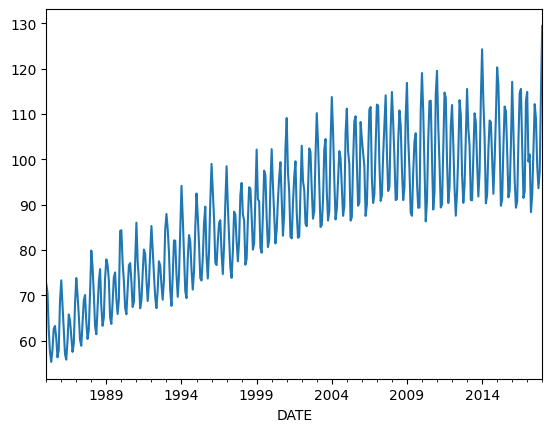

In [19]:
season.observed.plot()

<Axes: xlabel='DATE'>

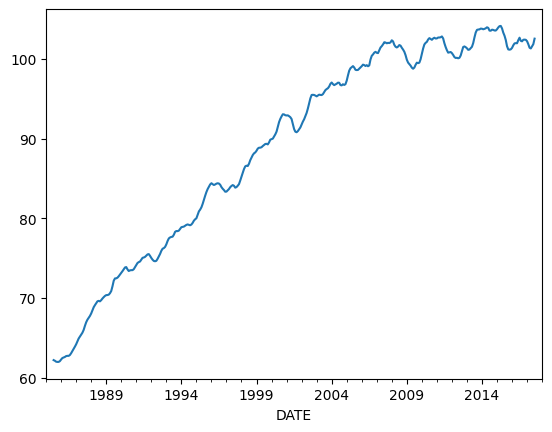

In [20]:
season.trend.plot()

<Axes: xlabel='DATE'>

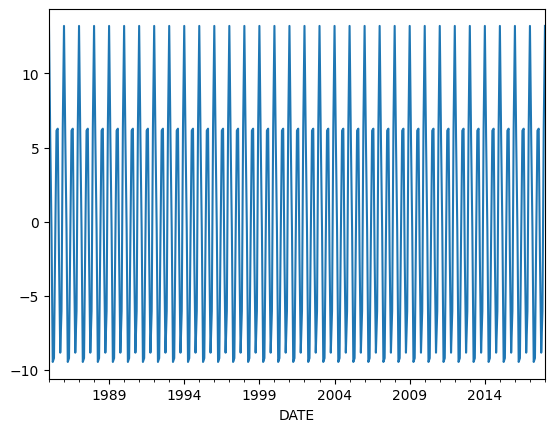

In [21]:
season.seasonal.plot()

<Axes: xlabel='DATE'>

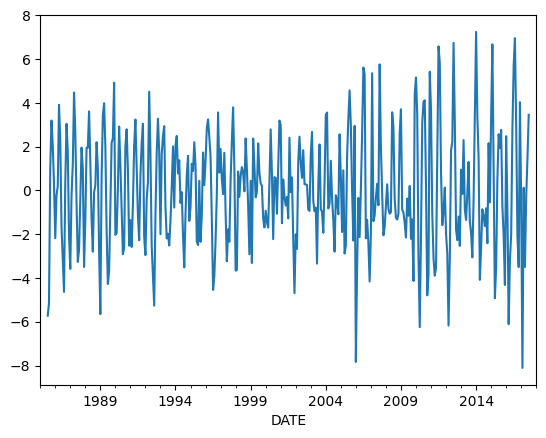

In [22]:
season.resid.plot()

# ADFuller Test for stationarity Check.

In [23]:
result = adfuller(df['Value'])

In [24]:
print('ADFuller Test Result.')
print(f'Adf Statistics:{result[0]:.4f}')
print(f'P value:{result[1]:.4f}')
print('Critical Values:')
for key,value in result[4].items():
    print(f'\t{key}:{value:.4f}')

ADFuller Test Result.
Adf Statistics:-2.2570
P value:0.1862
Critical Values:
	1%:-3.4476
	5%:-2.8692
	10%:-2.5708


Series is non stationary as p value > 0.05.We fail to reject the null hypothesis.

**Let's plot PACF plot**

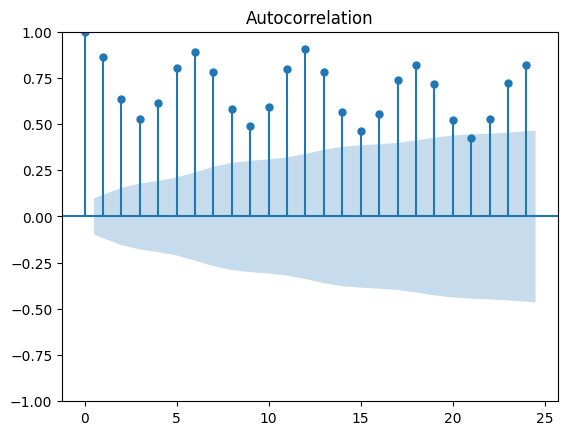

In [25]:
plot_acf(df['Value'],lags=24)
plt.show()

q value should be 0.

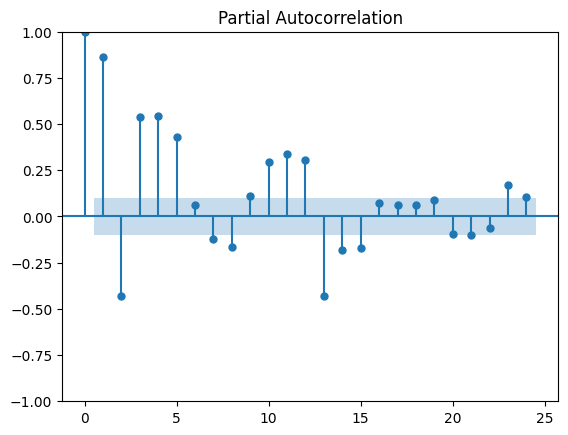

In [26]:
plot_pacf(df['Value'], lags=24, method='yw')  # Adjust 'lags' as needed
plt.show()

Since Lag 1 and Lag 2 are significant, this suggests that an AR(2) model might be appropriate.
If using ARIMA(p, d, q), choose p = 2 based on PACF.

In [27]:
result2 = adfuller(df['Value'].diff().fillna(0))
print('ADFuller Test Result.')
print(f'Adf Statistics:{result2[0]:.4f}')
print(f'P value:{result2[1]:.4f}')
print('Critical Values:')
for key,value in result2[4].items():
    print(f'\t{key}:{value:.4f}')

ADFuller Test Result.
Adf Statistics:-7.0854
P value:0.0000
Critical Values:
	1%:-3.4476
	5%:-2.8691
	10%:-2.5708


On first order differencing we got stationary series we can choose d = 1 in a ARIMA model.

# Model Building

As the data has seasonality we are choosing SARIMA model.

In [28]:
model = SARIMAX(df['Value'],order=(2,1,0),seasonal_order=(1,1,1,12))

C:\Users\levyg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\levyg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [29]:
results = model.fit()

In [30]:
df['Predicted'] = results.fittedvalues

<Axes: xlabel='DATE'>

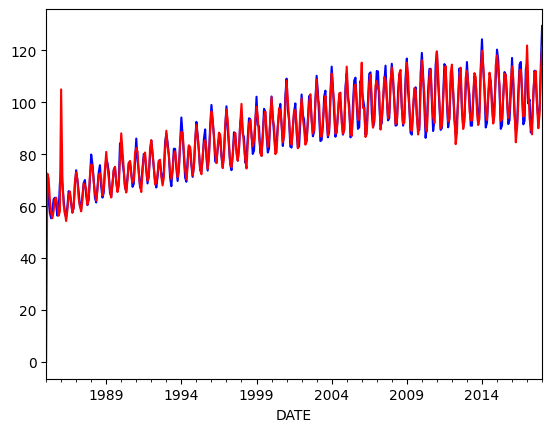

In [31]:
df['Value'].plot(color='#0000FF')
df['Predicted'].plot(color='#FF0000')

In [32]:
forecast = results.predict(start=len(df), end=len(df) + 80, dynamic=True)
forecast


2018-02-01    116.325940
2018-03-01    109.103685
2018-04-01     98.928300
2018-05-01    101.298719
2018-06-01    111.841309
                 ...    
2024-06-01    127.910882
2024-07-01    137.364385
2024-08-01    136.266493
2024-09-01    125.632095
2024-10-01    117.628462
Freq: MS, Name: predicted_mean, Length: 81, dtype: float64

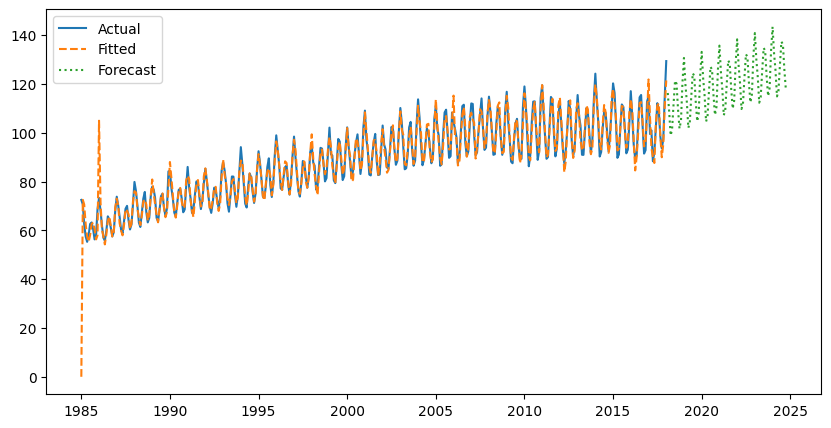

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(df['Value'], label='Actual')
plt.plot(df.index, df['Predicted'], label='Fitted', linestyle='dashed')
plt.plot(forecast, label='Forecast', linestyle='dotted')
plt.legend()
plt.show()

.csv output save

In [ ]:
output_df = pd.DataFrame({
    'Actual': df['Value'],
    'Predicted': df['Predicted']
})

forecast_df = pd.DataFrame({
    'Forecast': forecast
})
output_df = pd.concat([output_df, forecast_df], axis=1)

# Save to CSV
output_df.to_csv('sarimax_results.csv', index=True)  # Ensure the index (dates) is saved

Creating fictional sensor logs for practicing in Grafana

In [ ]:
import random

# Gerar datas de 1985-01-01 até 2018-01-01 (1º dia de cada mês)
date_range = pd.date_range(start="1985-01-01", end="2018-01-01", freq="MS")

# Criar valores fictícios de consumo de energia (exemplo baseado nos seus dados)
energy_consumption = np.random.uniform(50, 150, size=len(date_range))

# Níveis de log e status do sistema
log_levels = ["INFO", "WARN", "ERROR", "CRITICAL"]
system_statuses = ["OK", "WARNING", "ERROR", "CRITICAL"]
alerts = ["None", "Deviation Detected", "Sensor Issue", "Consumption Drop"]

# Criar DataFrame de logs
logs = pd.DataFrame({
    "Timestamp": date_range,
    "Level": np.random.choice(log_levels, size=len(date_range), p=[0.7, 0.15, 0.1, 0.05]),  # Maior probabilidade de INFO
    "Message": [
        random.choice([
            "Data collected successfully",
            "Slight deviation in energy consumption",
            "Sensor malfunction detected",
            "Major drop in energy consumption",
        ])
        for _ in range(len(date_range))
    ],
    "Energy_Consumption": energy_consumption.round(2),
    "System_Status": np.random.choice(system_statuses, size=len(date_range), p=[0.7, 0.15, 0.1, 0.05]),
    "Alert": np.random.choice(alerts, size=len(date_range), p=[0.7, 0.15, 0.1, 0.05])
})

# Salvar em CSV
logs.to_csv("energy_logs.csv", index=False)

# Exibir as primeiras linhas
print(logs.head())
